In [3]:
import numpy as np
import pandas as pd
from pyscheduling.FS import FmCmax, FlowShop
import pickle
import time
import matplotlib.pyplot as plt
import numpy as np
import random

## Makespan

In [4]:
def compute_makespan(schedule, p):
    _, m = p.shape
    n = len(schedule)
    c = [[0]*m for i in range(n)]
    for i in range(n):
        for j in range(m):
            if i == 0 and j == 0:
                c[i][j] = p[schedule[i]][j]
            elif i == 0:
                c[i][j] = c[i][j-1] + p[schedule[i]][j]
            elif j == 0:
                c[i][j] = c[i-1][j] + p[schedule[i]][j]
            else:
                c[i][j] = max(c[i][j-1], c[i-1][j]) + p[schedule[i]][j]
    return c[n-1][m-1]

## Heuristiques (pour l'initialisation)

In [28]:
def heuristique_Ham(M):
    m = M.shape[1]

    P1 = np.sum(M[:,:m//2], axis=1) # somme des durées sur la première machine
    P2 = np.sum(M[:,m//2:], axis=1) # somme des durées sur la deuxième machine
    P2_P1 = P2 - P1 # différence entre les deux sommes
    ordre = np.flip(np.argsort(P2_P1)) # tri par ordre décroissant

    # Première solution
    ordre_1 = ordre
    Cmax1 = compute_makespan(ordre_1 , M) # makespan de la première solution

    # Deuxième solution
    indice_positif = ordre[P2_P1[ordre] >= 0] # indices des tâches avec un indice positif ou nul
    indice_negatif = ordre[P2_P1[ordre] < 0] # indices des tâches avec un indice négatif

    indice_positif = [indice_positif[i] for i in np.argsort(P1[indice_positif])] # tri croissant selon P1
    indice_negatif = [indice_negatif[i] for i in np.flip(np.argsort(P2[indice_negatif]))] # tri décroissant selon P2
   
    ordre_2 = [int(i) for i in np.concatenate((indice_positif, indice_negatif))]
    Cmax2 = compute_makespan(ordre_2 , M) # makespan de la deuxième solution

    if (Cmax1 > Cmax2):
        return ordre_1, Cmax1
    else:
        return ordre_2, Cmax2
    

def heuristique_NEH(M):
    n , m = M.shape
    p = M.copy()

    # Step 1: Compute the processing time of each job
    processing_time = [sum(p[i]) for i in range(n)]

    # Step 2: Sort the jobs in decreasing order of processing time
    sorted_jobs = sorted(range(n), key=lambda i: processing_time[i], reverse=True)

    # Step 3: Initialize the schedule with the first job
    schedule = [sorted_jobs[0]]

    # Step 4: Insert each subsequent job into the schedule in a position that minimizes the makespan
    for i in range(1, n):
        best_pos = -1
        best_makespan = float('inf')
        for j in range(len(schedule)+1):
            temp_schedule = schedule[:j] + [sorted_jobs[i]] + schedule[j:]
            temp_makespan = compute_makespan(temp_schedule, p)
            if temp_makespan < best_makespan:
                best_makespan = temp_makespan
                best_pos = j
        schedule.insert(best_pos, sorted_jobs[i])

    return schedule, compute_makespan(schedule, p)


def johnson_method(processing_times):
    
    jobs, machines = processing_times.shape
    #print(jobs,machines)
    copy_processing_times = processing_times.copy()
    maximum = processing_times.max() + 1
    m1 = []
    m2 = []
    
    if machines != 2:
        raise Exception("Johson method only works with two machines")
        
    for i in range(jobs):
        minimum = copy_processing_times.min()
        position = np.where(copy_processing_times == minimum)
        
        if position[1][0] == 0:
            m1.append(position[0][0])
        else:
            m2.insert(0, position[0][0])
        
        copy_processing_times[position[0][0]] = maximum
        # Delete the job appended
    return m1+m2


def heuristique_CDS(M):
    m = M.shape[1]
    solutions = []
    makespans = []

    for k in range(1,m):
        P1 = M[:,0:k].sum(axis=1) # sommer les durées sur les k premières machines
        P2 = M[:,m-k:m].sum(axis=1) # sommer les durées sur les m-k dernières machines
        P1_P2 = np.hstack([P1[:,None],P2[:,None]]) # créer une matrice à deux colonnes avec P1 et P2

        johnson_seq = johnson_method(P1_P2) # appliquer la méthode de Johnson sur P1_P2

        solutions.append(johnson_seq)
        makespans.append(np.apply_along_axis(compute_makespan, 0, johnson_seq, M)) # calculer le makespan de v avec M

    score = np.min(makespans) # trouver le score minimal
    return solutions[np.argmin(makespans)], score # renvoyer la solution correspondant au score minimal

# **Iterated Local Search proposée par dong et al (2009)**
##### (https://sci-hub.ru/10.1016/j.cor.2008.04.001)

## **Implémentation**

# Utils

In [6]:
def perform_insert(schedule, i, j):
    """
    Performs an INSERT move on the given permutation by moving the job at
    position i to position j.
    
     - i: the position of the job to be moved.
     - j: the position where the job should be inserted.
    """
    schedule=list(schedule)
    new_schedule = schedule.copy()
    job = new_schedule.pop(i)
    new_schedule.insert(j, job)
    return new_schedule

def pairwise_permute_n(schedule, n_perturb):
    """
    Performs n random pairwise permutations between elements in a list.
    
    """
    new_schedule = schedule.copy()
    for i in range(n_perturb):
        idx1, idx2 = random.sample(range(len(new_schedule)), 2)
        new_schedule[idx1], new_schedule[idx2] = new_schedule[idx2], new_schedule[idx1]
    return new_schedule

# job here is the index of job in the schedule not the job 
# saying schedule [3,0,2,1]  job=1 is 3, job =2 is 0 ...
def completeion_time_of_job(machine,job,schedule,processing_times):
    if(job==1):
        cmp=0
        for r in range(machine):
            cmp=cmp+processing_times[schedule[0]][r]
        return cmp
    elif(machine==1):
        cmp=0
        for r in range(job):
            cmp=cmp+processing_times[schedule[r]][0]
        return cmp
    else:
        e1=completeion_time_of_job(machine-1,job,schedule,processing_times)
        e2=completeion_time_of_job(machine,job-1,schedule,processing_times)
        return processing_times[job-1][machine-1]+max(e1,e2)

### L'algorithme ILS

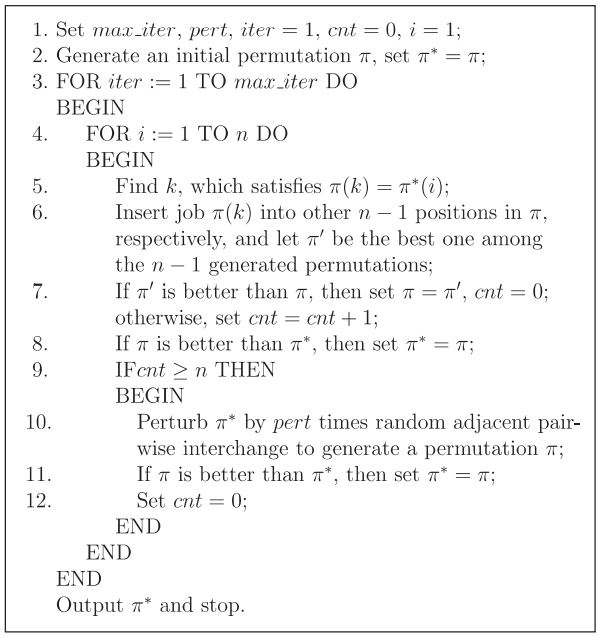

In [7]:
def dong_et_al_ils(schedule,processing_times,max_iter,n_perturb):
    n_jobs , n_machines = processing_times.shape
    cnt=0
    schedule=list(schedule)
    schedule_best=schedule.copy()
    
    for itr in range(max_iter):
        for j in range(n_jobs):
            
            #selecting the k
            k=schedule.index(schedule_best[j])#step 5 of the algorithm
            obj = 0
            schedule_optim=schedule.copy()
            for e in range(n_jobs):
                if (k!=e) :
                    new_schedule=perform_insert(schedule, k, e)
                    new_obj = compute_makespan(new_schedule, processing_times)
                    if(new_obj<obj):
                        schedule_optim=new_schedule.copy()
                        obj = new_obj

            #step 7
            if(compute_makespan(schedule_optim, processing_times)<compute_makespan(schedule, processing_times)):
                schedule=schedule_optim.copy()
                cnt=0
            else:
                cnt=cnt+1

            if(compute_makespan(schedule, processing_times)<compute_makespan(schedule_best, processing_times)):
                schedule_best=schedule.copy()

            if(cnt>=n_jobs):
                ss=pairwise_permute_n(schedule_best, n_perturb)
                if(compute_makespan(ss, processing_times)<compute_makespan(schedule_best, processing_times)):
                    schedule_best=ss.copy()
                cnt=0
    return schedule_best,compute_makespan(schedule_best, processing_times)

## **Tests et analyse**

###  **Sur l'instance aléatoire**  :

Avec l'instance aléatoire qui a comme fonction objectif optimale : **1102**, nous avons exécuté une recherche locale itérée sur une solution donnée par des heuristiques telles que : Ham et NEH ILS a amélioré cette solution de **1107** vers **1105** comme fonction objectif, avec les paramètres de l'algorithme fixés à 1000 itérations et 4 perturbations, il est à noter que la variation des paramètres n'a pas influencé la solution donnée par ILS pour cette instance, les résultats sont montrés ci-dessous :

-------Instance aléatoire---------


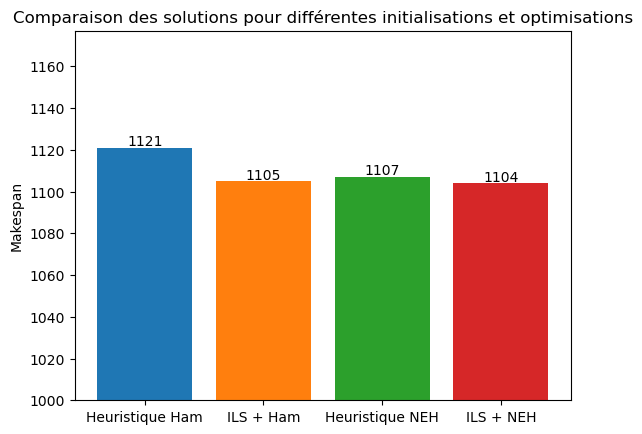

In [29]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)

#Run the algorithms
schedule_ham, makespan_ham = heuristique_Ham(processing_times)
schedule_ils_ham, makespan_ils_ham = dong_et_al_ils(schedule_ham, processing_times, 1000, 4)
schedule_neh, makespan_neh = heuristique_NEH(processing_times)
schedule_ils_neh, makespan_ils_neh = dong_et_al_ils(schedule_neh, processing_times, 1000, 4)

# Plot the results as a bar chart
labels = ['Heuristique Ham', 'ILS + Ham', 'Heuristique NEH', 'ILS + NEH']
makespans = [makespan_ham, makespan_ils_ham, makespan_neh, makespan_ils_neh]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plt.bar(labels, makespans, color=colors)
plt.ylabel('Makespan')
plt.title('Comparaison des solutions pour différentes initialisations et optimisations')

# Set the minimum value of the y-axis to 1000
plt.ylim(bottom=1000)

# Add the values as text above the bars
for i, v in enumerate(makespans):
    plt.text(i, v + 1, str(v), ha='center')

plt.show()


### **Sur les instances de Taillard** :
Dans cette section, nous allons tester l'effet des différents paramètres initiaux :
- Nombre d'itérations : de 100 à 1000 itérations.
- Intensité de perturbatios : de 4 à 7 perturbations, car d'après l'article, il est plus approprié de fixer l'intensité de la perturbation entre 4 et 7.

Ainsi que les différentes initalisations :
- Ham.
- NEH.
- CDS.

Sur la performance de ILS avec les **10 instances** du **premier Benchmark de Taillard**.

In [8]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)


### Nombre d'itérations & Déviation avec la première instance du Benchmark:
Les autres paramètres sont fixés ainsi : 
- Initialisation : CDS.
- Nombre de perturbations : 4.

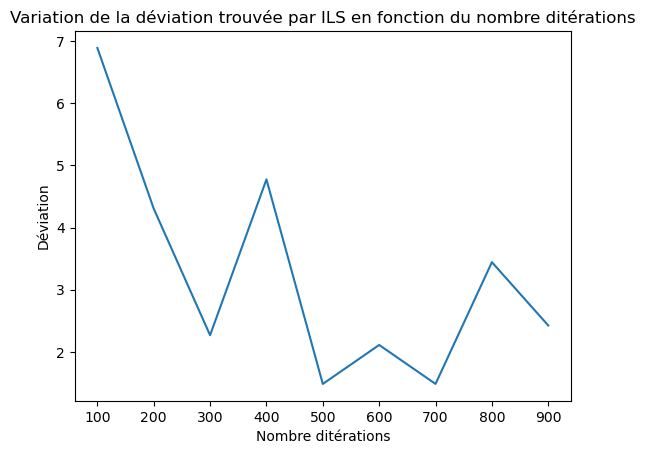

In [31]:

nb_perturb=4
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_CDS(processing_times)
iter=[]
dev=[]
times=[]
for max_iter in range(100,1000,100):
    iter.append(max_iter)
    start_time = time.time()
    schedule,obj=dong_et_al_ils(init_schedule,processing_times,max_iter,nb_perturb)
    end_time = time.time()
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)
    elapsed_time = end_time - start_time
    times.append(elapsed_time)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(iter, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### Intensité de perturbation & déviation avec la première instance du Benchmark :
Les autres paramètres sont fixés comme suit : 
- Initialisation : Ham.
- Nombre d'itérations : 100.

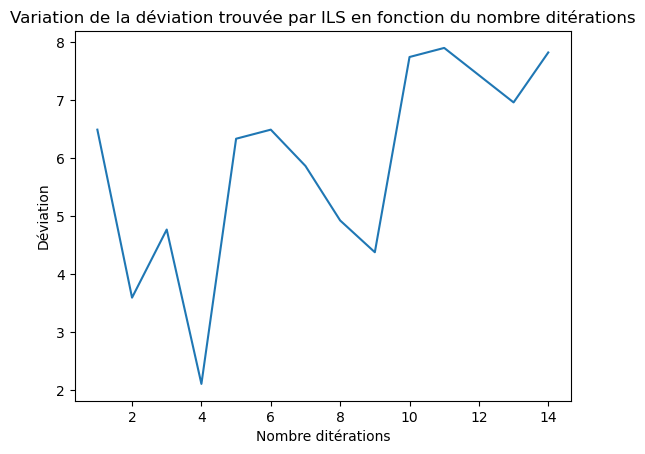

In [23]:
max_iter=100
processing_times = np.array(taillard[0]["P"]).transpose()
upper_bound = taillard[0]["ub"]
init_schedule,init_obj=heuristique_Ham(processing_times)
perturb=[]
dev=[]
times=[]
for nb_perturb in range(1,15,1):
    perturb.append(nb_perturb)
    start_time = time.time()
    schedule,obj=dong_et_al_ils(init_schedule,processing_times,max_iter,nb_perturb)
    end_time = time.time()
    dev.append(100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound)
    elapsed_time = end_time - start_time
    times.append(elapsed_time)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the data
ax.plot(perturb, dev)

# Add axis labels and a title
ax.set_xlabel('Nombre ditérations')
ax.set_ylabel('Déviation')
ax.set_title('Variation de la déviation trouvée par ILS en fonction du nombre ditérations')

# Display the graph
plt.show()

### Conclusion sur l'effet des deux paramètres : 
Vu la nature aléatoire de l'algorithme dans la phase des perturbations, on ne peut pas généraliser l'effet du nombre des itérations sur la déviation obtenue par rapport aux instances de Taillard, mais le nombre de perturbations a clairement un effet sur la performance de l'algorithme, trop pertuber va donner un caractère aléatoire excessif à l'algorithme qui ne sera pas bon pour l'optimisation, mais si l'intensité de perturbation est trop faible, l'algorithme aura relativement peu de chances de sortir d'une zone locale.

### Effet de l'initialisation sur la déviation obtenue :
Dans ce test, nous allons initialiser avec Ham et NEH pour les 10 instances du 1er Benchmark en fixant le nombre d'itérations à 100 et l'intensité de perturbation à 4.

In [32]:
max_iter=100
nb_perturb=4
dev_Ham=[]
dev_NEH=[]
dev_CDS=[]
dev_ham_ils=[]
dev_neh_ils=[]
dev_cds_ils=[]
instances=list(range(1,11))
for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    schedule_ham, makespan_ham = heuristique_Ham(processing_times)
    schedule_ils_ham, makespan_ils_ham = dong_et_al_ils(schedule_ham, processing_times, max_iter, nb_perturb)
    schedule_neh, makespan_neh = heuristique_NEH(processing_times)
    schedule_ils_neh, makespan_ils_neh = dong_et_al_ils(schedule_neh, processing_times, max_iter, nb_perturb)
    schedule_cds, makespan_cds = heuristique_CDS(processing_times)
    schedule_ils_cds, makespan_ils_cds = dong_et_al_ils(schedule_cds, processing_times, max_iter, nb_perturb)
    dev_Ham.append(100*(makespan_ham-upper_bound)/upper_bound)
    dev_NEH.append(100*(makespan_neh-upper_bound)/upper_bound)
    dev_CDS.append(100*(makespan_cds-upper_bound)/upper_bound)
    dev_ham_ils.append(100*(makespan_ils_ham-upper_bound)/upper_bound)
    dev_neh_ils.append(100*(makespan_ils_neh-upper_bound)/upper_bound)
    dev_cds_ils.append(100*(makespan_ils_cds-upper_bound)/upper_bound)

In [43]:
print(dev_cds_ils)
print(dev_CDS)
instances

[4.225352112676056, 2.2810890360559233, 10.730804810360777, 6.419180201082753, 5.744336569579288, 6.945606694560669, 5.488297013720743, 8.872305140961858, 8.048780487804878, 4.783393501805054]
[8.763693270735525, 4.7829286239882265, 15.541165587419057, 9.667440061871616, 7.038834951456311, 9.790794979079498, 12.429378531073446, 11.194029850746269, 10.56910569105691, 5.054151624548736]


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [47]:
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)



fig = go.Figure()
fig.add_trace(go.Bar(
    x=instances,
    y=dev_Ham,
    name='Ham',
    marker_color='steelblue'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_ham_ils,
    name='Ham+ILS',
    marker_color='teal'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_CDS,
    name='CDS',
    marker_color='darkred'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_cds_ils,
    name='CDS+ILS',
    marker_color='palevioletred'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_NEH,
    name='NEH',
    marker_color='darkgoldenrod'
))
fig.add_trace(go.Bar(
    x=instances,
    y=dev_neh_ils,
    name='NEH+ILS',
    marker_color='orange'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, xaxis_title ="Instance", yaxis_title="Deviation", title_text="Déviations obtenues par ILS avec différentes initialisations heuristiques")
fig.show()

# New Tests

In [30]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
i=0
max_iter=200
nb_perturb=4
M = np.array(taillard[i]["P"]).transpose()
upper_bound = taillard[i]["ub"]
schedule,b=heuristique_CDS(M)
processing_times=M
schedule=list(schedule)
upper_bound,schedule,compute_makespan(schedule, M)

for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    init_schedule,init_obj=heuristique_CDS(processing_times)
    start_time = time.time()
    schedule,obj=dong_et_al_ils(init_schedule,processing_times,max_iter,nb_perturb)
    end_time = time.time()
    print("-------------- Instance ",i+1,"------------------")
    print("instance",i+1,":","deviation: ",100*(compute_makespan(schedule,processing_times)-upper_bound)/upper_bound,"% ")
    print("improved compared to Ham : ",100*(init_obj-obj)/(init_obj-upper_bound))
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("-------------------------------------------------\n\n")

-------------- Instance  1 ------------------
instance 1 : deviation:  1.486697965571205 % 
improved compared to Ham :  83.03571428571429
Elapsed time: 5.501362085342407 seconds
-------------------------------------------------


-------------- Instance  2 ------------------
instance 2 : deviation:  1.030169242089772 % 
improved compared to Ham :  78.46153846153847
Elapsed time: 5.652413606643677 seconds
-------------------------------------------------


-------------- Instance  3 ------------------
instance 3 : deviation:  7.493061979648473 % 
improved compared to Ham :  51.785714285714285
Elapsed time: 5.523793697357178 seconds
-------------------------------------------------


-------------- Instance  4 ------------------
instance 4 : deviation:  7.115235885537509 % 
improved compared to Ham :  26.4
Elapsed time: 5.5186684131622314 seconds
-------------------------------------------------


-------------- Instance  5 ------------------
instance 5 : deviation:  5.4207119741100325 %

In [114]:
max_iter=400
n_jobs=20
n_machines=5
schedule_best=schedule
cnt=0
pert_times=6
for i in range(max_iter):
    for j in range(n_jobs):
        
        #selecting the k
        k=0
        # obj=completeion_time_of_job(n_machines,1,schedule,processing_times)
        # for e in range(n_jobs-1):
        #     if(completeion_time_of_job(n_machines,e+1,schedule,processing_times)<obj):
        #         obj=completeion_time_of_job(n_machines,e+1,schedule,processing_times)
        #         k=e
        k=np.where(np.array(schedule),schedule_best[i])

        # do insertions:
        obj=compute_makespan(schedule, processing_times)
        schedule_fat7a=schedule
        schedule_optim=schedule
        for e in range(n_jobs):
            new_schedule=perform_insert(schedule, k, e)
            if(compute_makespan(new_schedule, processing_times)<obj):
                schedule_optim=new_schedule
        
        if(compute_makespan(schedule_optim, processing_times)<compute_makespan(schedule, processing_times)):
            schedule=schedule_optim
            cnt=0
        else:
            cnt=cnt+1
        
        if(compute_makespan(schedule, processing_times)<compute_makespan(schedule_best, processing_times)):
            schedule_best=schedule
        
        if(cnt>=n_jobs):
            ss=pairwise_permute_n(schedule_best, pert_times)
            if(compute_makespan(ss, processing_times)<compute_makespan(schedule_best, processing_times)):
                schedule_best=ss
            cnt=0
compute_makespan(schedule_best, processing_times),schedule_best

(1297, [14, 3, 2, 15, 12, 0, 18, 8, 7, 16, 4, 5, 11, 17, 6, 10, 1, 13, 9, 19])

## Guided Local Search 

### Tabu Search

### Pseudo code:
1-Initialize the tabu list and set the initial solution as the current solution.
2-Define a neighborhood structure that generates candidate solutions by swapping adjacent jobs in the current solution.
3-Evaluate the quality of the initial solution using an objective function that measures the total processing time on all machines.
4-Repeat until a stopping criterion is met:
    a. Generate a set of candidate solutions by applying the neighborhood structure to the current solution.
    b. Remove any candidate solutions that are in the tabu list.
    c. Evaluate the remaining candidate solutions using the objective function.
    d. Select the best candidate solution as the new current solution.
    e. Update the tabu list with the current solution.
    f. If the new current solution is better than the best solution found so far, update the best solution.
5Return the best solution found.

In [40]:
def tabu_search(init_schedule,processing_times, neighbors_size=10, max_iter=1000, tabu_size=10):
    
    n_jobs , n_machines = processing_times.shape
    current_schedule = init_schedule.copy()
    best_schedule = init_schedule.copy()
    
    tabu_list = []
    
    iter = 0
    for _ in range(max_iter):
        
        # Générer un ensemble de solutions candidates
        candidates = []
        for i in range(neighbors_size):
            candidate = current_schedule.copy()
            j = random.randint(0, n_jobs-2)
            k = random.randint(j+1, n_jobs-1)
            candidate[j:k+1] = reversed(candidate[j:k+1])
            
            # Supprimer le candidat s'il figure dans la liste taboue
            if(candidate not in tabu_list):
                candidates.append(candidate)
        
        # Évaluer les solutions candidates restantes
        candidate_scores = [compute_makespan(candidate, processing_times) for candidate in candidates]
        
        # Sélectionner la meilleure solution candidate comme nouvelle solution actuelle
        best_candidate_idx = min(range(len(candidate_scores)), key=lambda i: candidate_scores[i])
        current_schedule = candidates[best_candidate_idx]
        
        # Ajouter la solution actuelle à la liste taboue
        tabu_list.append(current_schedule.copy())
        if len(tabu_list) > tabu_size:
            tabu_list.pop(0)
            
        # Vérifier si le meilleur candidat est meilleur que la solution actuelle
        if candidate_scores[best_candidate_idx] < compute_makespan(best_schedule, processing_times):
            best_schedule = current_schedule.copy()

    return best_schedule

## Tests

In [37]:
instance=FmCmax.FmCmax_Instance.read_txt("../TP02-Heuristiques/data/random_instance.txt")
processing_times = np.array(instance.P)
# schedule,b=heuristique_Ham(M)
# upper_bound,schedule,compute_makespan(schedule, M)
processing_times

array([[71, 79, 85, 82, 83],
       [84, 71, 66, 68, 81],
       [78, 81, 75, 72, 87],
       [78, 75, 66, 72, 88],
       [72, 88, 83, 85, 88],
       [86, 88, 79, 82, 78],
       [75, 66, 86, 78, 78],
       [80, 79, 66, 83, 78],
       [73, 73, 67, 77, 71],
       [80, 77, 83, 78, 67]])

In [38]:
initial_solution = list(range(10))
random.shuffle(initial_solution)
compute_makespan(tabu_search(initial_solution, processing_times,neighbors_size=20, max_iter=5000, tabu_size=100),processing_times)

1102

### taillard

In [50]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
i=0;
max_iter=5000
tabu_size=100
neighbors_size=20
for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    init_schedule=list(range(20));
    random.shuffle(init_schedule)
    init_obj=compute_makespan(init_schedule,processing_times)
    start_time = time.time()
    schedule=tabu_search(init_schedule, processing_times,neighbors_size, max_iter, tabu_size)
    end_time = time.time()
    obj=compute_makespan(schedule,processing_times)
    print("-------------- Instance ",i+1,"------------------")
    print("instance",i+1,":","deviation: ",100*(obj-upper_bound)/upper_bound,"% ")
    print("improved compared to init solution: ",100*(init_obj-obj)/(init_obj-upper_bound))
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("-------------------------------------------------\n\n")

-------------- Instance  1 ------------------
instance 1 : deviation:  0.0 % 
improved compared to init solution:  100.0
Elapsed time: 5.7258055210113525 seconds
-------------------------------------------------


-------------- Instance  2 ------------------
instance 2 : deviation:  0.07358351729212656 % 
improved compared to init solution:  99.46236559139786
Elapsed time: 5.869294881820679 seconds
-------------------------------------------------


-------------- Instance  3 ------------------
instance 3 : deviation:  0.7400555041628122 % 
improved compared to init solution:  97.4921630094044
Elapsed time: 5.828875541687012 seconds
-------------------------------------------------


-------------- Instance  4 ------------------
instance 4 : deviation:  0.6187161639597835 % 
improved compared to init solution:  97.2508591065292
Elapsed time: 5.937375783920288 seconds
-------------------------------------------------


-------------- Instance  5 ------------------
instance 5 : deviatio

In [52]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
i=0;
max_iter=5000
tabu_size=10
neighbors_size=40
for i in range(10):
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    init_schedule=list(range(20));
    random.shuffle(init_schedule)
    init_obj=compute_makespan(init_schedule,processing_times)
    start_time = time.time()
    schedule=tabu_search(init_schedule, processing_times,neighbors_size, max_iter, tabu_size)
    end_time = time.time()
    obj=compute_makespan(schedule,processing_times)
    print("-------------- Instance ",i+1,"------------------")
    print("instance",i+1,":","deviation: ",100*(obj-upper_bound)/upper_bound,"% ")
    print("improved compared to init solution: ",100*(init_obj-obj)/(init_obj-upper_bound))
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("-------------------------------------------------\n\n")

-------------- Instance  1 ------------------
instance 1 : deviation:  0.0 % 
improved compared to init solution:  100.0
Elapsed time: 12.948039770126343 seconds
-------------------------------------------------


-------------- Instance  2 ------------------
instance 2 : deviation:  0.515084621044886 % 
improved compared to init solution:  92.78350515463917
Elapsed time: 13.03857684135437 seconds
-------------------------------------------------


-------------- Instance  3 ------------------
instance 3 : deviation:  0.0 % 
improved compared to init solution:  100.0
Elapsed time: 13.531136512756348 seconds
-------------------------------------------------


-------------- Instance  4 ------------------
instance 4 : deviation:  0.46403712296983757 % 
improved compared to init solution:  97.63779527559055
Elapsed time: 12.997552394866943 seconds
-------------------------------------------------


-------------- Instance  5 ------------------
instance 5 : deviation:  -0.08090614886731391

In [54]:
f =  open("../TP02-Heuristiques/data/Taillard.pkl", "rb")
taillard = pickle.load(f)
i=0;
max_iter=5000
tabu_size=10
neighbors_size=40
for i in range(1):
    i=4
    processing_times = np.array(taillard[i]["P"]).transpose()
    upper_bound = taillard[i]["ub"]
    init_schedule=list(range(20));
    random.shuffle(init_schedule)
    init_obj=compute_makespan(init_schedule,processing_times)
    start_time = time.time()
    schedule=tabu_search(init_schedule, processing_times,neighbors_size, max_iter, tabu_size)
    end_time = time.time()
    obj=compute_makespan(schedule,processing_times)
    print("-------------- Instance ",i+1,"------------------")
    print(schedule,obj,upper_bound)
    print("instance",i+1,":","deviation: ",100*(obj-upper_bound)/upper_bound,"% ")
    print("improved compared to init solution: ",100*(init_obj-obj)/(init_obj-upper_bound))
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time} seconds")
    print("-------------------------------------------------\n\n")

-------------- Instance  5 ------------------
[11, 18, 2, 8, 3, 9, 16, 15, 1, 12, 4, 14, 5, 10, 13, 6, 17, 0, 19, 7] 1235 1236
instance 5 : deviation:  -0.08090614886731391 % 
improved compared to init solution:  100.47846889952153
Elapsed time: 11.21304178237915 seconds
-------------------------------------------------


